In [ ]:
# === 1. Setup ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# === 2. Load Preprocessed Data ===
data_path = "/content/drive/MyDrive/CIC-IDS-2017/final_cgan_ready_scaled.csv"
df = pd.read_csv(data_path)

# Select only attack samples (classes 1–4)
df_attack = df[df["Label"] != 0].copy()
feature_cols = df_attack.columns[df_attack.columns != "Label"]
num_features = len(feature_cols)
num_classes = df_attack["Label"].nunique()
print("🔹 Attack-only shape:", df_attack.shape)

# Split into features and labels
X_attack = df_attack[feature_cols].values.astype(np.float32)
y_attack = df_attack["Label"].values.astype(np.int64)

# === 3. One-Hot Encode Labels ===
ohe = OneHotEncoder(sparse_output=False, categories='auto')
y_ohe = ohe.fit_transform(y_attack.reshape(-1, 1)).astype(np.float32)
class_dim = y_ohe.shape[1]

# === 4. Dataset and Dataloader ===
class AttackDataset(Dataset):
    def __init__(self, features, labels):
        self.x = torch.tensor(features)
        self.y = torch.tensor(labels)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

batch_size = 256
attack_dataset = AttackDataset(X_attack, y_ohe)
attack_loader = DataLoader(attack_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# === 5. IGAN Generator & Discriminator ===
class Generator(nn.Module):
    def __init__(self, noise_dim, class_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + class_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim),
        )

    def forward(self, z, labels):
        x = torch.cat([z, labels], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, in_dim, class_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim + class_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = torch.cat([x, labels], dim=1)
        return self.model(x)

# === 6. Training Setup ===
noise_dim = 100
G = Generator(noise_dim, class_dim, num_features).to(device)
D = Discriminator(num_features, class_dim).to(device)

criterion = nn.BCELoss()
lr = 1e-4
G_opt = optim.Adam(G.parameters(), lr=lr)
D_opt = optim.Adam(D.parameters(), lr=lr)

# === 7. Train Loop ===
num_epochs = 500
real_label, fake_label = 1.0, 0.0
print_freq = 10

for epoch in range(1, num_epochs + 1):
    for real_data, real_labels in attack_loader:
        real_data = real_data.to(device)
        real_labels = real_labels.to(device)
        batch_size = real_data.size(0)

        # === Train Discriminator ===
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_data = G(z, real_labels)

        D_real = D(real_data, real_labels)
        D_fake = D(fake_data.detach(), real_labels)

        d_loss = criterion(D_real, torch.full_like(D_real, real_label)) + \
                 criterion(D_fake, torch.full_like(D_fake, fake_label))

        D_opt.zero_grad()
        d_loss.backward()
        D_opt.step()

        # === Train Generator ===
        fake_data = G(z, real_labels)
        D_fake = D(fake_data, real_labels)
        g_loss = criterion(D_fake, torch.full_like(D_fake, real_label))

        G_opt.zero_grad()
        g_loss.backward()
        G_opt.step()

    if epoch % print_freq == 0 or epoch == 1 or epoch == num_epochs:
        print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# === 8. Save Generator and Discriminator ===
model_dir = "/content/drive/MyDrive/CIC-IDS-2017/models"
os.makedirs(model_dir, exist_ok=True)
torch.save(G.state_dict(), os.path.join(model_dir, "IGAN_Generator_Attempt3.pt"))
torch.save(D.state_dict(), os.path.join(model_dir, "IGAN_Discriminator_Attempt3.pt"))
print("📂 Generator and Discriminator saved.")

# === 9. Generate and Save Synthetic Data ===
def generate_synthetic_attacks(n_per_class=1000):
    synth_data, synth_labels = [], []
    for i in range(class_dim):
        label_vec = np.zeros((n_per_class, class_dim), dtype=np.float32)
        label_vec[:, i] = 1
        label_vec_t = torch.tensor(label_vec).to(device)
        z = torch.randn(n_per_class, noise_dim).to(device)
        fake_samples = G(z, label_vec_t).detach().cpu().numpy()
        synth_data.append(fake_samples)
        synth_labels.extend([i] * n_per_class)

    X_synth = np.vstack(synth_data)
    y_synth = np.array(synth_labels)
    return X_synth, y_synth

X_synth, y_synth = generate_synthetic_attacks(n_per_class=1000)
df_synth = pd.DataFrame(X_synth, columns=feature_cols)
df_synth["Label"] = y_synth

csv_path = "/content/drive/MyDrive/CIC-IDS-2017/IGAN_Attempt3_Synthetic.csv"
df_synth.to_csv(csv_path, index=False)
print("✅ Synthetic data exported:", csv_path)


✅ Using device: cuda
🔹 Attack-only shape: (31740, 75)
Epoch [1/500] | D Loss: 1.3582 | G Loss: 0.8002
Epoch [10/500] | D Loss: 0.8145 | G Loss: 1.2807
Epoch [20/500] | D Loss: 0.8941 | G Loss: 1.3023
Epoch [30/500] | D Loss: 0.9183 | G Loss: 1.1789
Epoch [40/500] | D Loss: 0.9562 | G Loss: 1.2534
Epoch [50/500] | D Loss: 0.9139 | G Loss: 1.2957
Epoch [60/500] | D Loss: 0.8934 | G Loss: 1.2557
Epoch [70/500] | D Loss: 0.6553 | G Loss: 1.5009
Epoch [80/500] | D Loss: 0.9244 | G Loss: 1.3442
Epoch [90/500] | D Loss: 0.8394 | G Loss: 1.4403
Epoch [100/500] | D Loss: 0.7359 | G Loss: 1.3949
Epoch [110/500] | D Loss: 0.6566 | G Loss: 1.5970
Epoch [120/500] | D Loss: 0.6993 | G Loss: 1.5306
Epoch [130/500] | D Loss: 0.8693 | G Loss: 1.3474
Epoch [140/500] | D Loss: 0.5942 | G Loss: 1.6568
Epoch [150/500] | D Loss: 0.6925 | G Loss: 1.5588
Epoch [160/500] | D Loss: 0.7320 | G Loss: 1.4900
Epoch [170/500] | D Loss: 0.8070 | G Loss: 1.4005
Epoch [180/500] | D Loss: 0.7865 | G Loss: 1.3994
Epoch [

🔍 Step 1: Visualising t-SNE & PCA...


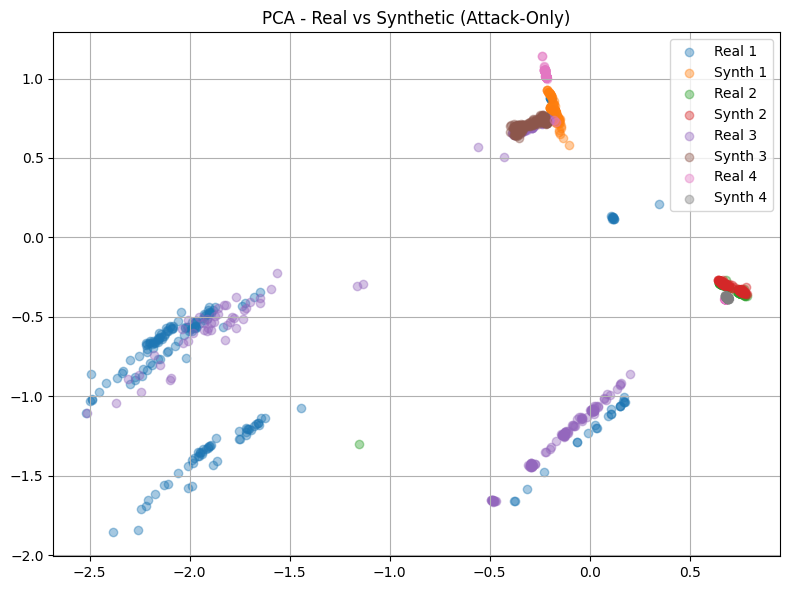

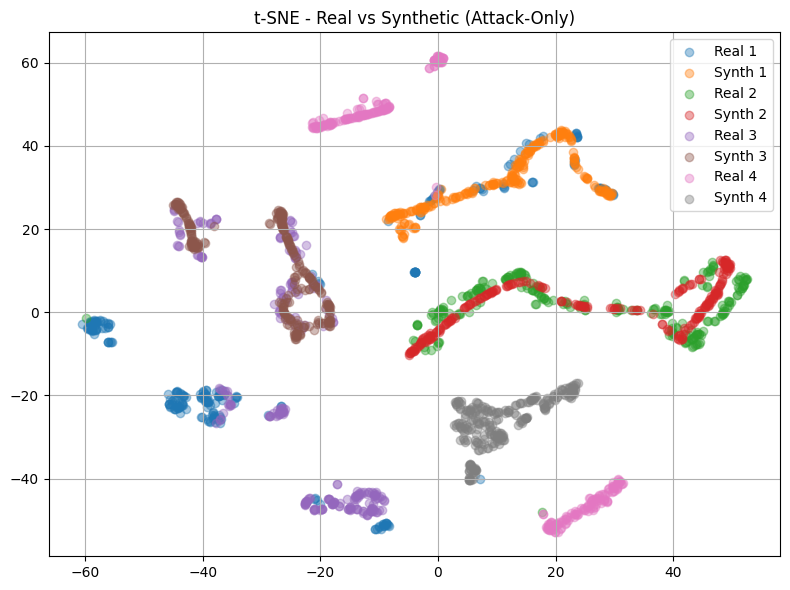

📐 Step 2: Silhouette & μ-distance...
Class 1 → Silhouette: 0.3967 | Δμ: 1.7181
Class 2 → Silhouette: 0.0129 | Δμ: 0.0640
Class 3 → Silhouette: 0.3169 | Δμ: 1.2706
Class 4 → Silhouette: 0.3764 | Δμ: 1.0456
📊 Step 3: F1 Score (Real vs Augmented)...
F1 (Real only):     0.9987
F1 (Real+Synth):    0.9988
🧪 Step 4: Binary Classifier Accuracy...
Binary Classifier Accuracy (Real vs Fake): 0.7900


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch

# === Parameters ===
attack_classes = [1, 2, 3, 4]
num_attack_classes = len(attack_classes)
class_to_idx = {label: idx for idx, label in enumerate(attack_classes)}
idx_to_class = {idx: label for label, idx in class_to_idx.items()}

# === Sampling Function ===
def generate_samples_attack_only(G, class_id, n_samples=500):
    G.eval()
    z = torch.randn(n_samples, noise_dim, device=device)
    labels = torch.full((n_samples,), class_id, dtype=torch.long, device=device)
    onehot = F.one_hot(labels, num_classes=num_attack_classes).float()
    with torch.no_grad():
        generated = G(z, onehot).cpu().numpy()
    return generated

# === Extract real data ===
X = df.drop("Label", axis=1).values
y = df["Label"].values
X_real = {class_id: df[df["Label"] == class_id].drop("Label", axis=1).values for class_id in attack_classes}

# === 1. PCA & t-SNE Visualisation ===
def visualise_tsne_pca(G):
    samples_synth = np.vstack([generate_samples_attack_only(G, class_to_idx[i], 250) for i in attack_classes])
    labels_synth = np.hstack([[i] * 250 for i in attack_classes])
    samples_real = np.vstack([X_real[i][:250] for i in attack_classes])
    labels_real = np.hstack([[i] * 250 for i in attack_classes])

    X_comb = np.vstack([samples_real, samples_synth])
    y_comb = np.hstack([labels_real, labels_synth + 10])  # +10 to separate classes visually

    for method, name in [(PCA(n_components=2), "PCA"), (TSNE(n_components=2, perplexity=30, random_state=42), "t-SNE")]:
        X_proj = method.fit_transform(X_comb)
        plt.figure(figsize=(8, 6))
        for class_id in attack_classes:
            plt.scatter(X_proj[y_comb == class_id, 0], X_proj[y_comb == class_id, 1], label=f"Real {class_id}", alpha=0.4)
            plt.scatter(X_proj[y_comb == class_id + 10, 0], X_proj[y_comb == class_id + 10, 1], label=f"Synth {class_id}", alpha=0.4)
        plt.title(f"{name} - Real vs Synthetic (Attack-Only)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# === 2. Silhouette Score and μ-distance ===
def silhouette_and_mu(G):
    for class_id in attack_classes:
        real = X_real[class_id][:300]
        fake = generate_samples_attack_only(G, class_to_idx[class_id], 300)
        combined = np.vstack([real, fake])
        labels = np.array([0]*len(real) + [1]*len(fake))
        sil_score = silhouette_score(combined, labels)
        mu_distance = np.linalg.norm(real.mean(axis=0) - fake.mean(axis=0))
        print(f"Class {class_id} → Silhouette: {sil_score:.4f} | Δμ: {mu_distance:.4f}")

# === 3. F1 Score Real vs Real+Synth ===
def f1_real_vs_augmented(G):
    clf = RandomForestClassifier()
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    clf.fit(X_train, y_train)
    f1_real = f1_score(y_test, clf.predict(X_test), average="macro")

    X_synth = np.vstack([generate_samples_attack_only(G, class_to_idx[i], 1000) for i in attack_classes])
    y_synth = np.hstack([[i]*1000 for i in attack_classes])
    X_train_aug = np.vstack([X_train, X_synth])
    y_train_aug = np.hstack([y_train, y_synth])

    clf_aug = RandomForestClassifier()
    clf_aug.fit(X_train_aug, y_train_aug)
    f1_aug = f1_score(y_test, clf_aug.predict(X_test), average="macro")

    print(f"F1 (Real only):     {f1_real:.4f}")
    print(f"F1 (Real+Synth):    {f1_aug:.4f}")
    return f1_real, f1_aug

# === 4. Binary Real vs Fake Classifier ===
def binary_accuracy(G):
    real = np.vstack([X_real[i][:300] for i in attack_classes])
    fake = np.vstack([generate_samples_attack_only(G, class_to_idx[i], 300) for i in attack_classes])
    X_comb = np.vstack([real, fake])
    y_comb = np.array([0]*len(real) + [1]*len(fake))

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_comb, y_comb)
    acc = clf.score(X_comb, y_comb)
    print(f"Binary Classifier Accuracy (Real vs Fake): {acc:.4f}")
    return acc

# === Final Evaluation Runner ===
def run_full_evaluation(G):
    print("🔍 Step 1: Visualising t-SNE & PCA...")
    visualise_tsne_pca(G)

    print("📐 Step 2: Silhouette & μ-distance...")
    silhouette_and_mu(G)

    print("📊 Step 3: F1 Score (Real vs Augmented)...")
    f1_real, f1_aug = f1_real_vs_augmented(G)

    print("🧪 Step 4: Binary Classifier Accuracy...")
    acc_bin = binary_accuracy(G)

    return {
        "F1_Real": round(f1_real, 4),
        "F1_Augmented": round(f1_aug, 4),
        "Binary_Accuracy": round(acc_bin, 4)
    }

# === Run Evaluation ===
results = run_full_evaluation(G)

In [ ]:
print("Unique labels in y_attack:", np.unique(y_attack))
print("class_to_idx:", class_to_idx)

Unique labels in y_attack: [1 2 3 4]
class_to_idx: {1: 0, 2: 1, 3: 2, 4: 3}


✅ Running on: cpu
✔️ Filtering labels...
Mapped labels: [0 1 2 3]
✔️ Converting to tensors...
🧪 Shapes → X: torch.Size([31740, 74]) | y_onehot: torch.Size([31740, 4])
🧪 X_fake shape: torch.Size([31740, 74])


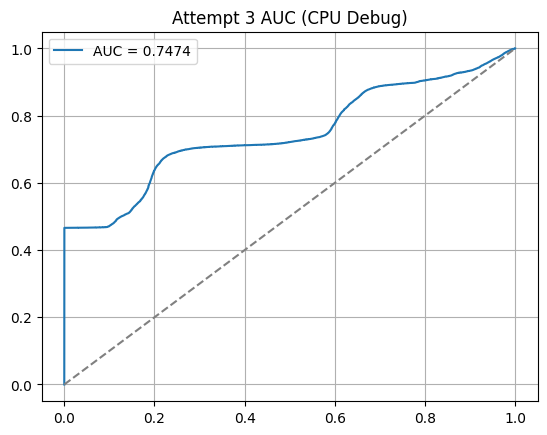

✅ AUC (CPU debug): 0.7474
✅ Returned AUC (CPU-safe): 0.7473516910793392


In [ ]:
# === Define model architecture ===
G_loaded = Generator(noise_dim, len(class_to_idx), X_attack.shape[1])
D_loaded = Discriminator(X_attack.shape[1], len(class_to_idx))

# === Load model weights (CPU-safe) ===
G_loaded.load_state_dict(torch.load("/content/drive/MyDrive/CIC-IDS-2017/models/IGAN_Generator_Attempt3.pt", map_location='cpu'))
D_loaded.load_state_dict(torch.load("/content/drive/MyDrive/CIC-IDS-2017/models/IGAN_Discriminator_Attempt3.pt", map_location='cpu'))

G_loaded.eval()
D_loaded.eval()

# === Evaluate AUC on CPU ===
auc3 = evaluate_auc_roc_attempt3_debug(D_loaded, G_loaded, X_attack, y_attack, noise_dim, class_to_idx)
print("✅ Returned AUC (CPU-safe):", auc3)